In [110]:
import importlib
import src.MyPlotting

importlib.reload(src.MyPlotting)

<module 'src.MyPlotting' from 'C:\\Users\\lovas\\Desktop\\Market_risk_prediction\\src\\MyPlotting.py'>

In [111]:
import pandas as pd
from joblib import dump, load

import sys
from pathlib import Path

# Add project root to sys.path
project_root = Path().resolve().parent # assumes notebook is in a subdirectory of the project root
sys.path.append(str(project_root))

from src.utils import best_threshold, train_test_by_time
from src.MyPlotting import plot_permutation_importance_v2, plot_curves_in_one, plot_abs_importances
from src.evaluation import load_top_models, give_metrics


In [4]:
normalized_features = ['Vol20/VIX', 'Vol5/VIX', 'Scaled_Lag_1d', 'Scaled_Lag_3d',
                       'Sharpe-like_10', 'Sharpe-like_5', 'log_returns_zscore' ,'VIX_zscore']

normalized_features += ['Momentum5_20', 'Momentum10_20', 'Momentum5_10', 'Momentum3_20', 'Momentum3_10', 'Momentum3_5'] # 5_20 is the original
normalized_features += ['Scaled_weighted_avg']

In [5]:
sp500 = pd.read_csv(project_root / "data/processed/sp500_processed.csv", index_col=0, parse_dates=True)
nasdaq = pd.read_csv(project_root / "data/processed/nasdaq_processed.csv", index_col=0, parse_dates=True)
dax = pd.read_csv(project_root / "data/processed/dax_processed.csv", index_col=0, parse_dates=True)

_, X_sp500, _,  y_sp500 = train_test_by_time(sp500)
_, X_nasdaq, _,  y_nasdaq = train_test_by_time(nasdaq)
_, X_dax, _,  y_dax = train_test_by_time(dax)

markets = {'SP500': (X_sp500[normalized_features], y_sp500),
           'Nasdaq': (X_nasdaq[normalized_features], y_nasdaq),
           'DAX': (X_dax[normalized_features], y_dax)}

In [6]:
models, metrics = load_top_models(project_root / "results/top_models.jsonl", project_root / "results/models")

In [7]:
folds_dict = {}
params_dict = {}

for name, d in metrics.items():
    params_dict[name] = d['params']
    folds_dict[name] = d["folds"]

In [8]:
folds_df = pd.DataFrame(folds_dict)

In [9]:
params_df = pd.DataFrame(params_dict)

In [10]:
proba_dict = {}
pred_dict = {}
best_thresholds = {}

for name, model in models.items():
    for market, (X_test, y_test) in markets.items():
        proba_dict[(market, name)] = model.predict_proba(X_test)[:, 1]
        best_thresholds[(market, name)] = best_threshold(y_test, proba_dict[(market, name)])
        pred_dict[(market, name)] = proba_dict[(market, name)] > best_thresholds[(market, name)]

0.38999999999999985
0.36999999999999983
0.4449999999999998
0.3549999999999998
0.32499999999999984
0.37499999999999983
0.33999999999999986
0.3549999999999998
0.4349999999999998
0.34499999999999986
0.31999999999999984
0.3649999999999998
0.36999999999999983
0.37499999999999983
0.4449999999999998


In [11]:
metrics = pd.DataFrame()
for (market, name) in proba_dict:
    y_test = markets[market][1]
    metrics = give_metrics(y_test, pred_dict[(market,name)], proba_dict[(market, name)], df=metrics, model_name=f"{market} - {name}")

In [12]:
thresholds_series = pd.Series(best_thresholds)

In [13]:
metrics.index = pd.MultiIndex.from_tuples([tuple(i.split(' - ')) for i in metrics.index], names=["Market", "Model"])

In [14]:
metrics['best_thresholds'] = pd.Series(best_thresholds)
metrics

,,Accuracy,Precision,Recall,F1 Score,ROC AUC,Average Precision,best_thresholds
Market,Model,,,,,,,
SP500,RF_1,0.856293,0.177778,0.413793,0.248705,0.746510,0.173111,0.390
Nasdaq,RF_1,0.744301,0.187023,0.521277,0.275281,0.700047,0.165834,0.370
DAX,RF_1,0.894789,0.213483,0.339286,0.262069,0.682009,0.132092,0.445
SP500,RF_2,0.840436,0.167742,0.448276,0.244131,0.743881,0.172612,0.355
Nasdaq,RF_2,0.720515,0.188742,0.606383,0.287879,0.695977,0.161826,0.325
DAX,RF_2,0.852507,0.164286,0.410714,0.234694,0.676973,0.130880,0.375
SP500,RF_3,0.813677,0.157895,0.517241,0.241935,0.745422,0.165335,0.340
Nasdaq,RF_3,0.729435,0.192440,0.595745,0.290909,0.700116,0.162826,0.355
DAX,RF_3,0.882006,0.192308,0.357143,0.250000,0.684332,0.130572,0.435


In [15]:
proba_series = pd.Series(proba_dict)

In [16]:
feat_imp_dict = {}
for name, model in models.items():
    feat_imp_dict[name] = {k:v for (k,v) in zip(normalized_features, model.feature_importances_)}

In [37]:
feat_imp_df = pd.DataFrame(feat_imp_dict)

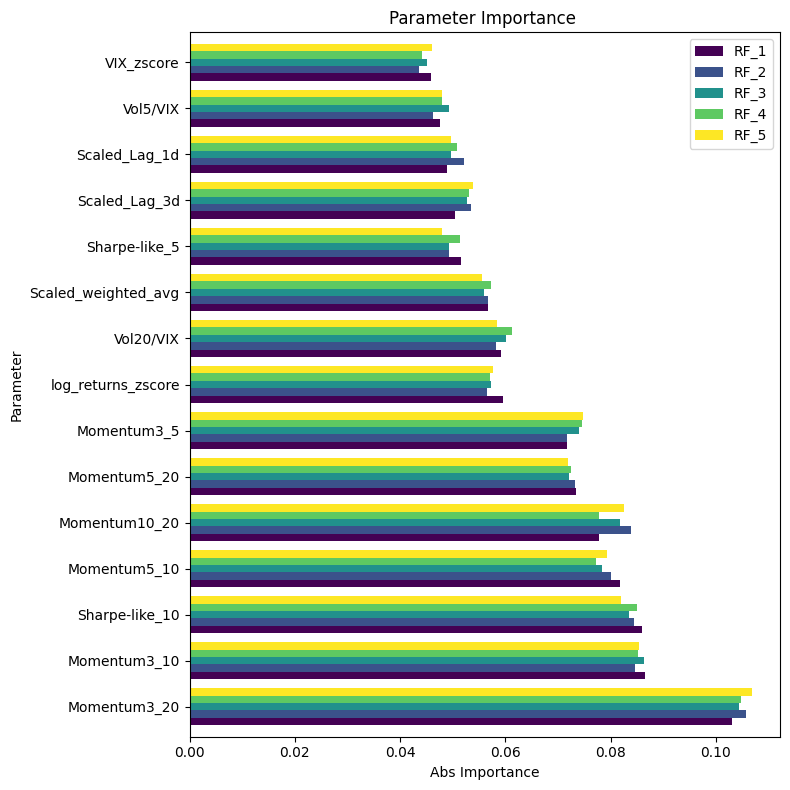

In [112]:
plot_abs_importances(feat_imp_df, True, project_root / "results/figures")

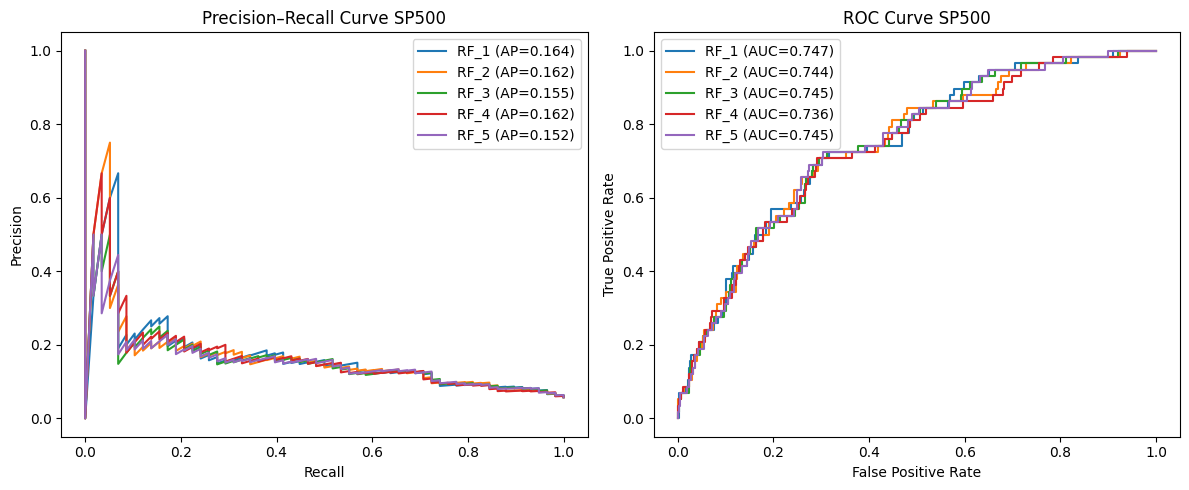

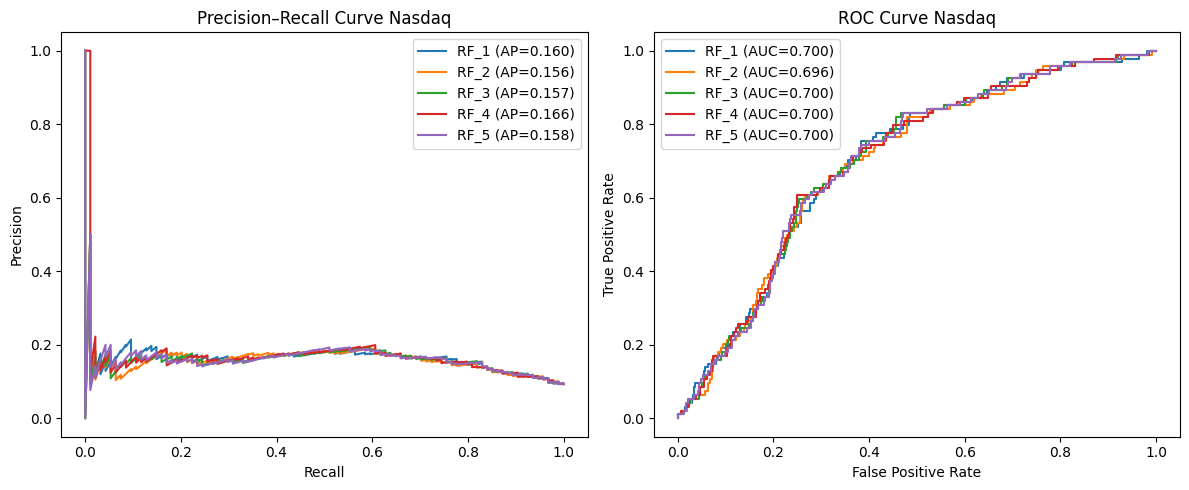

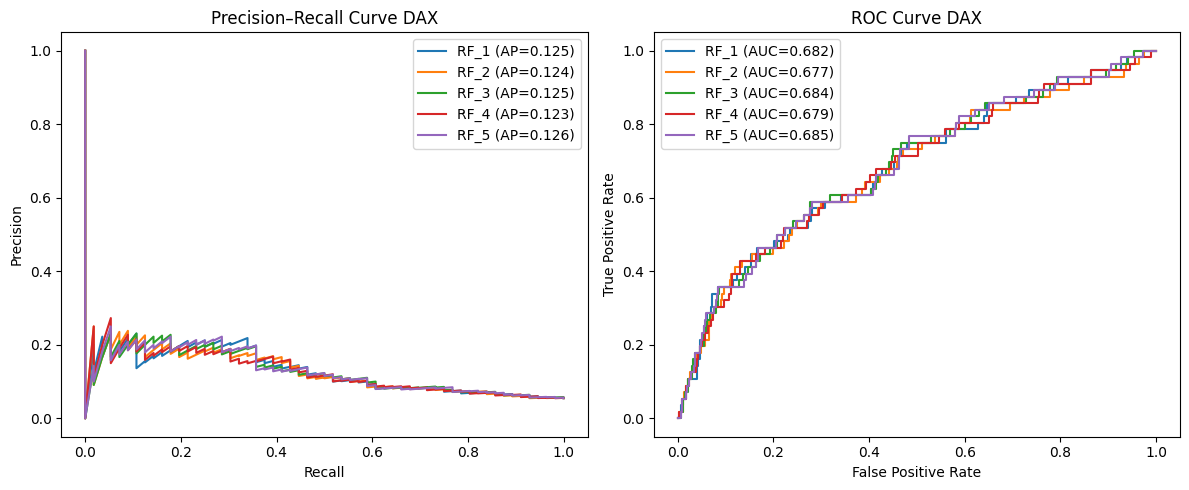

In [23]:
for market, (X_test, y_test) in markets.items():
    plot_curves_in_one(y_test, proba_series[market].to_dict(), identifier=market, save_png=True, file_path=project_root / "results/figures")

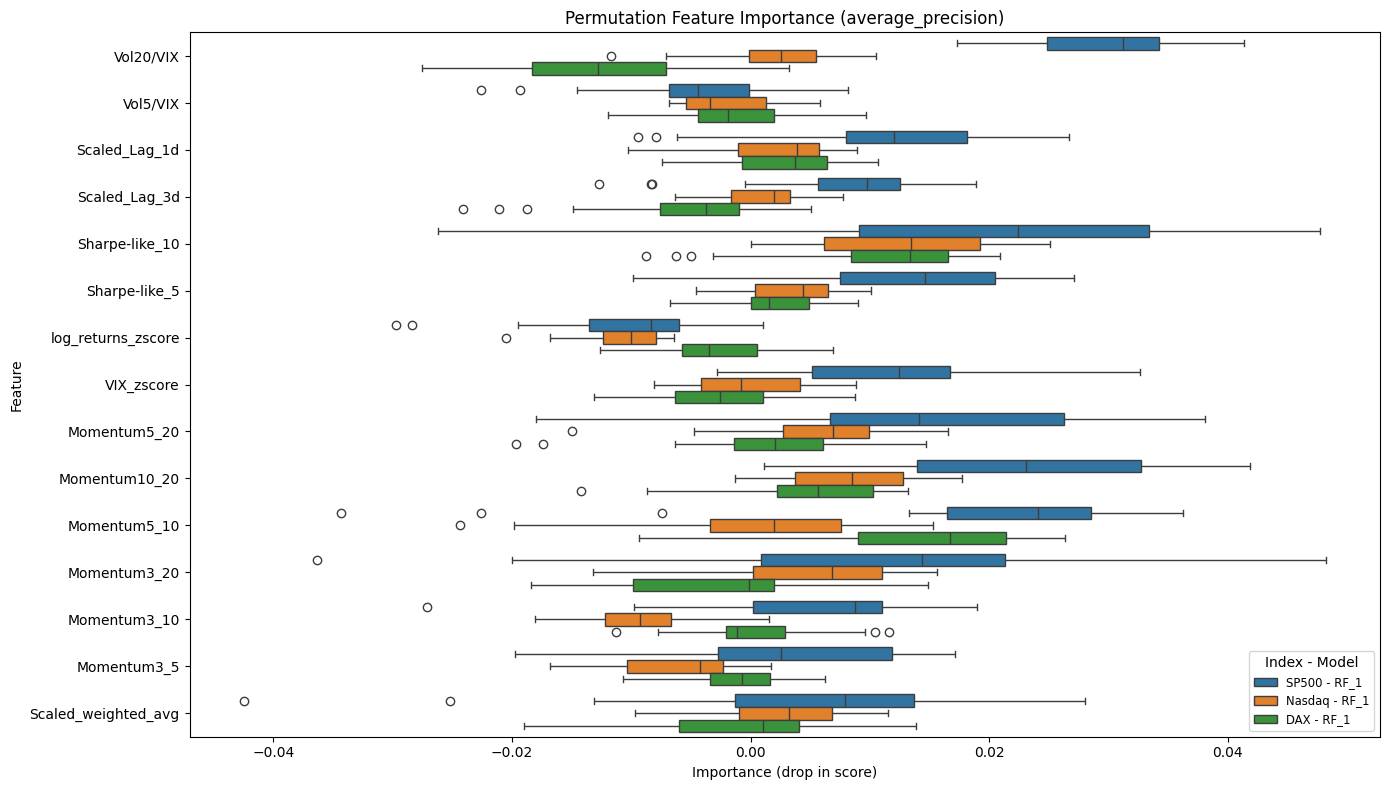

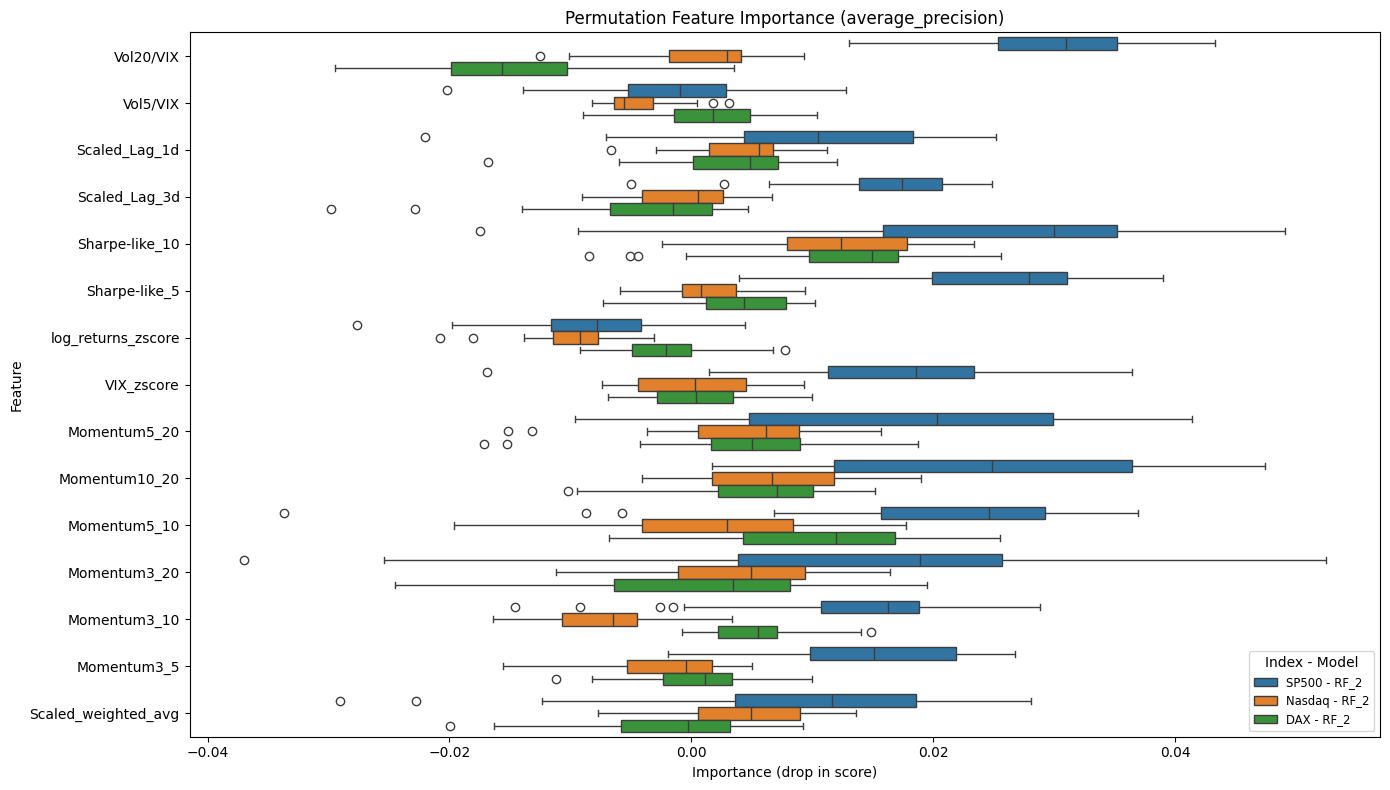

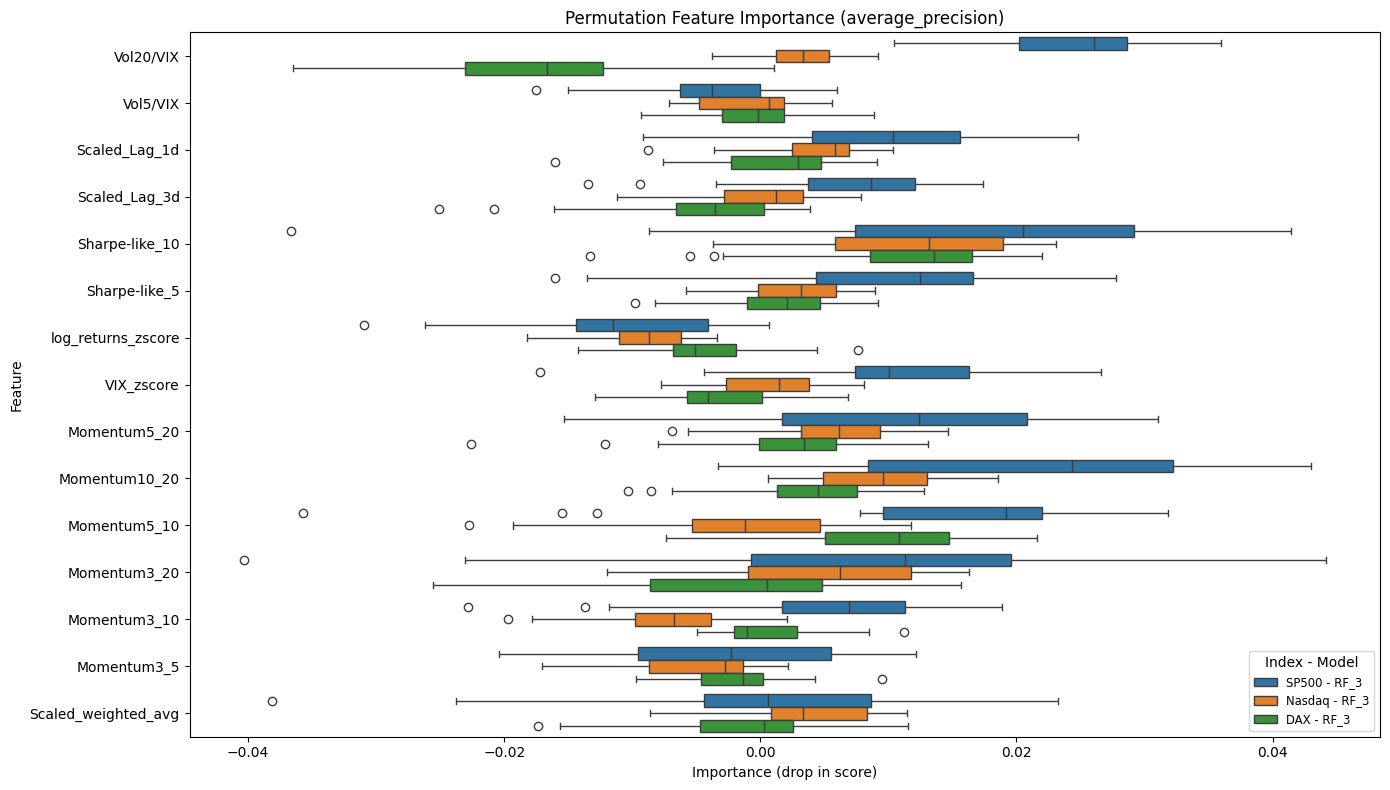

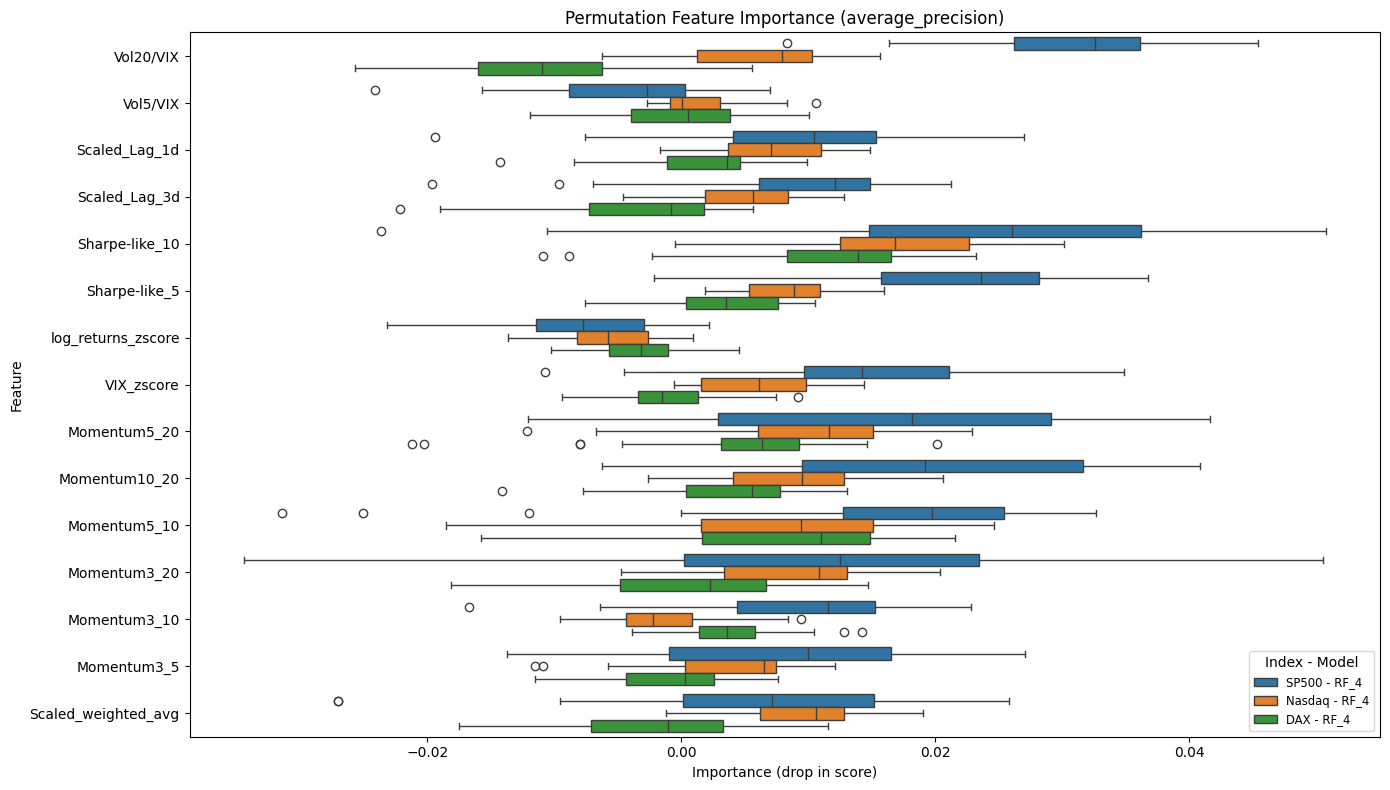

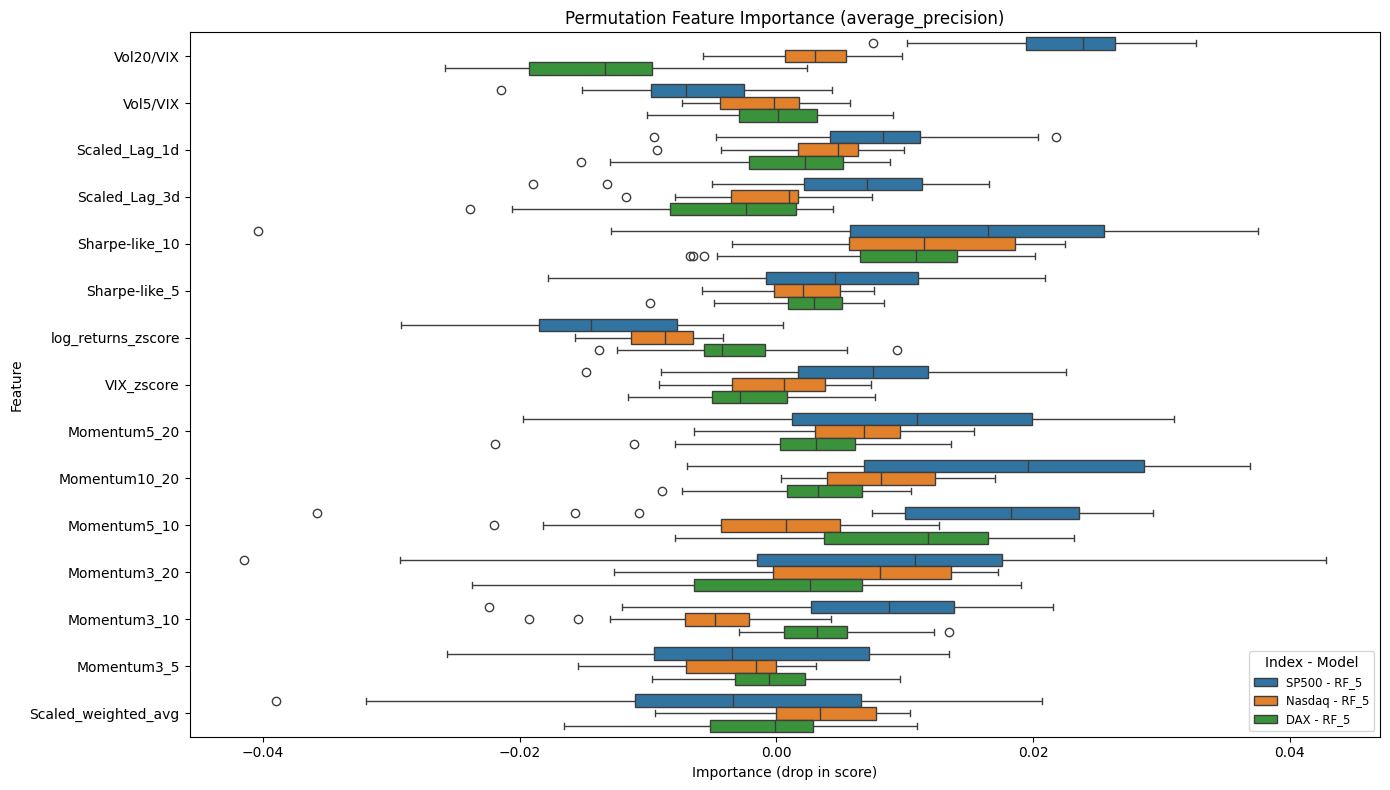

In [53]:
for model in models:
    plot_permutation_importance_v2(markets, {model: models[model]}, scoring='average_precision',
                                   save_png=True, file_path=project_root / "results/figures", identifier=model)

In [120]:
from src.reporting import make_pdf_report

make_pdf_report(metrics, params_df, folds_df, markets.keys(), project_root / "results")